In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import create_param_list

In [2]:
nconf = 31
ndata = 400
L = 64
T_cr = 2.269 # critical temp for 2d ising
t_start = 2.1

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Ising")
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:12400


In [3]:
img_list, temp_list, answer_list = [], [], []
for num in range(nconf):
    for iconf in range(ndata):
        file = f"{prm_list[num][1]}{iconf}.npy"
        img_list.append(np.load(file))
        temp_list.append(prm_list[num][0])
        if prm_list[num][0] < T_cr:
            answer = 0
        else:
            answer = 1
        answer_list.append(answer)

img_dataset = np.array(img_list)

In [4]:
def plot_inference(prediction):
    xs, y1s, y2s = [], [], []
    sum_pred = 0
    count = 0

    for i in range(len(prediction)):
        if i == 0:
            sum_pred += prediction[i]
            count += 1
            xs.append(temp_list[i])
        else:
            if temp_list[i] != temp_list[i-1]:
                # y1s, y2sに格納
                prob = sum_pred/count
                y1s.append(1 - prob)
                y2s.append(prob)

                sum_pred = 0
                count = 0
                sum_pred += prediction[i]
                count += 1
                xs.append(temp_list[i])
            elif i == len(prediction)-1:
                # y1s, y2sに格納
                prob = sum_pred/count
                y1s.append(1 - prob)
                y2s.append(prob)
            else:
                sum_pred += prediction[i]
                count += 1
    # print(len(xs), len(y1s), len(y2s))

    plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed",
                color="gray", label=r"$T_c={}$".format(T_cr))
    plt.xlim(t_start, t_end)
    plt.plot(xs, y1s, label=r"$para$", marker="o", color="red")
    plt.plot(xs, y2s, label=r"$ferro$", marker="o", color="blue")
    plt.legend()
    plt.xlabel(r"$T$")
    plt.ylabel(r"Probability")
    plt.show()

[[0.60786486 0.60620327 0.60952645 ... 0.65549709 0.63334256 0.64109665]
 [0.78518603 0.80202526 0.81363067 ... 0.84230288 0.82705655 0.81249289]]


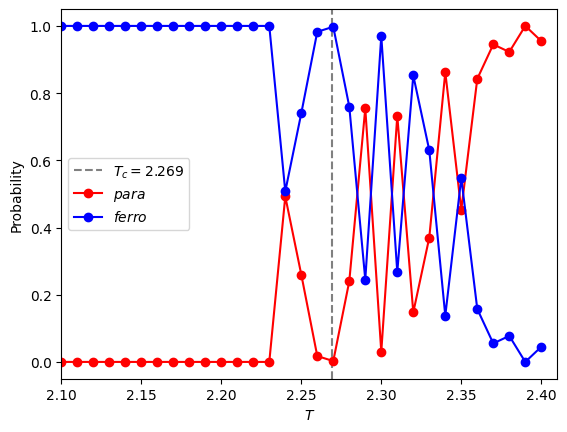

In [5]:
# flatten+kmeans
n_clusters = 2

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)
model = KMeans(n_clusters=n_clusters, n_init='auto').fit(img_dataset_flatten)

prediction = list(model.labels_)  # クラスタのラベル
# print(prediction)
centers = model.cluster_centers_  # クラスタの重心
print(centers)

plot_inference(prediction)

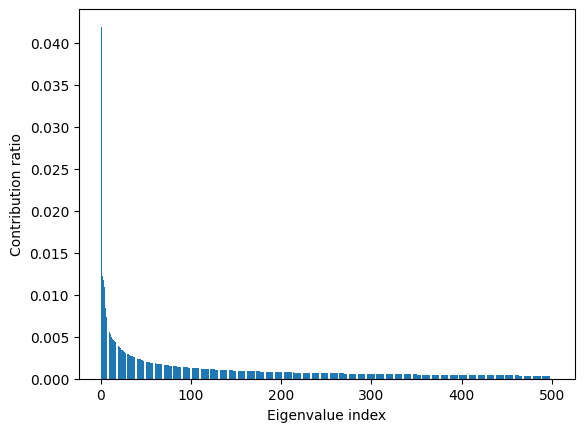

explained variance ratio 30% over
83


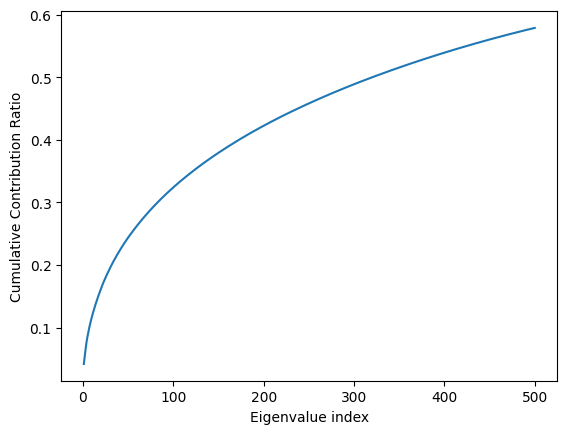

In [16]:
# 累積寄与率を決定する
n_components = 500

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)

pca = PCA(n_components=n_components)
pca.fit(img_dataset_flatten)
plt.xlabel("Eigenvalue index")
plt.ylabel("Contribution ratio")
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
plt.show()

total_ratio = 0
count = 0
ratio_list = []
is_over = False
for ratio in pca.explained_variance_ratio_:
    total_ratio += ratio
    count += 1
    ratio_list.append(total_ratio)
    if total_ratio > 0.30 and is_over == False:
        print(r"explained variance ratio 30% over")
        print(count)
        n_components_redution=count
        is_over = True
plt.xlabel("Eigenvalue index")
plt.ylabel("Cumulative Contribution Ratio")
plt.plot([n for n in range(1, len(pca.explained_variance_ratio_)+1)], ratio_list)
plt.show()

83
[[-4.71983139e+00  2.29757969e-01  5.15955780e-01 -2.24475973e-01
  -1.45266219e-01  9.78890887e-02  9.96571635e-02  1.16140826e-01
   1.64454406e-02 -5.00487315e-02  6.60258169e-02  3.29282525e-02
  -1.71842856e-01  1.42811473e-01 -2.58229022e-03 -2.55849030e-02
  -3.78825654e-02  3.53160293e-02  5.42426166e-02  3.51097873e-02
   2.68327981e-02  5.25185516e-02 -1.50505386e-01  1.04970100e-01
   1.56652957e-02 -1.81853084e-02 -3.32557974e-02  5.87322176e-02
   2.71308512e-02  2.32566634e-02 -1.70356984e-02  1.04108393e-03
   4.89485190e-02  7.15447783e-04 -3.58297550e-02  6.61304131e-02
  -7.52323415e-03 -3.13858054e-02  9.18812736e-03 -7.24192738e-02
   8.65909318e-03 -1.04197164e-02 -4.06559992e-03  2.02528478e-02
   4.60356765e-02  2.21302734e-02 -2.25713729e-02  2.29858302e-02
  -5.57122658e-02  4.10338516e-02 -3.71402391e-02  2.85642612e-02
  -8.27458848e-02  1.39776101e-02 -1.39773528e-02  6.01928422e-02
  -4.52053080e-02 -2.90017082e-02  2.40840713e-02 -2.03566955e-03
  -2.94

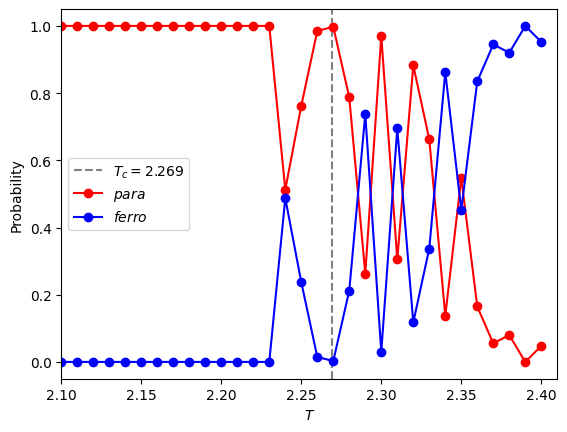

In [17]:
# flatten+PCA+kmeans
n_clusters = 2
print(n_components_redution)

img_dataset_flatten = img_dataset.reshape(img_dataset.shape[0], -1)

pca = PCA(n_components=n_components_redution)
pca.fit(img_dataset_flatten)
img_dataset_pca = pca.transform(img_dataset_flatten)
model = KMeans(
    n_clusters=n_clusters,
    n_init=50,
    max_iter=500,
    tol=0.01,
    algorithm="elkan"
).fit(img_dataset_pca)

prediction = list(model.labels_)  # クラスタのラベル
# print(prediction)
centers = model.cluster_centers_  # クラスタの重心
print(centers)

plot_inference(prediction)

In [8]:
# CNN+kmeans